In [12]:
import pickle
import os

import numpy as np
from torch_geometric.data import Data, Batch

import networkx as nx

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from torch.nn.utils.rnn import pad_sequence

import matplotlib.pyplot as plt

In [25]:
def preprocess_graph(G):
    node_features = []
    for node, data in G.nodes(data=True):
        features = [
            data['x'], data['y'],
            data['dynamic_object_exist_probability'],
            data['dynamic_object_position_X'], data['dynamic_object_position_Y'],
            data['dynamic_object_velocity_X'], data['dynamic_object_velocity_Y'],
            data['nearest_traffic_light_detection_probability']
        ]
        node_features.append(features)
    
    edge_index = []
    for edge in G.edges():
        edge_index.append([edge[0], edge[1]])
        #edge_index.append([edge[1], edge[0]])  # Add reverse edge for undirected graph
    
    # Convert to tensors and ensure node indices are zero-based
    x = torch.tensor(node_features, dtype=torch.float)
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    
    # Adjust node indices to be zero-based
    node_mapping = {old_idx: new_idx for new_idx, old_idx in enumerate(G.nodes())}
    edge_index = torch.tensor([[node_mapping[u], node_mapping[v]] for u, v in G.edges()], dtype=torch.long).t().contiguous()
    
    return x, edge_index

def prepare_batch(batch_graphs, max_nodes):
    x_seq, edge_index_seq = [], []
    x_last, edge_index_last = [], []
    y = []
    batch_last = []
    seq_lengths = []

    total_nodes_last = 0
    for batch_idx, graphs in enumerate(batch_graphs):
        seq_x, seq_edge_index = [], []
        for i, G in enumerate(graphs):
            x, edge_index = preprocess_graph(G)

            assert edge_index.max() < x.shape[0], f"Edge index out of bounds for graph {i} in batch {batch_idx}"

            # Pad the graph with additional nodes if necessary
            if x.shape[0] < max_nodes:
                padding = torch.zeros((max_nodes - x.shape[0], x.shape[1]))
                x = torch.cat([x, padding], dim=0)

            if i < 3:
                seq_x.append(x)
                seq_edge_index.append(edge_index)
            else:  # Last graph
                x_last.append(x)
                edge_index_last.append(edge_index + total_nodes_last)
                y.append(x[:, 2:])  # Target features
                batch_last.extend([batch_idx] * x.shape[0])  # Add batch index for each node
                total_nodes_last += x.shape[0]

        x_seq.append(seq_x)
        edge_index_seq.append(seq_edge_index)
        seq_lengths.append(len(seq_x))

    # Pad x_seq
    padded_x_seq = []
    for batch in zip(*x_seq):
        padded_batch = pad_sequence(batch, batch_first=True)
        padded_x_seq.append(padded_batch)

    padded_x_seq = torch.stack(padded_x_seq, dim=1)  # [batch_size, seq_len, max_nodes, features]

    # Process edge_index_seq
    max_edges = max(edge_index.shape[1] for batch in edge_index_seq for edge_index in batch)  # Maximum number of edges in the batch
    processed_edge_index_seq = []
    for batch in edge_index_seq:
        batch_edge_index = []
        for edge_index in batch:
            # Pad edge_index if necessary
            if edge_index.shape[1] < max_edges:
                padding = torch.zeros((2, max_edges - edge_index.shape[1]), dtype=edge_index.dtype)
                edge_index = torch.cat([edge_index, padding], dim=1)
            batch_edge_index.append(edge_index)
        processed_edge_index_seq.append(torch.stack(batch_edge_index))

    edge_index_seq = torch.stack(processed_edge_index_seq)

    # Concatenate all x_last and edge_index_last
    x_last = torch.cat(x_last, dim=0)
    edge_index_last = torch.cat(edge_index_last, dim=1)
    y = torch.cat(y, dim=0)
    batch_last = torch.tensor(batch_last, dtype=torch.long)
    seq_lengths = torch.tensor(seq_lengths, dtype=torch.long)

    assert edge_index_last.max() < x_last.shape[0], "Edge index out of bounds in last graph"

    return padded_x_seq, edge_index_seq, x_last, edge_index_last, y, batch_last, seq_lengths

def load_sequence_data(input_folder, batch_size=32):
    all_sequences = []
    max_nodes = 0

    for file_name in os.listdir(input_folder):
        file_path = os.path.join(input_folder, file_name)
        #print(f"Processing file: {file_name}")
        with open(file_path, 'rb') as f:
            sequences = pickle.load(f)

            # Check if the sequences list is not empty
            if sequences:
                all_sequences.extend(sequences)

                # Update the maximum number of nodes
                max_nodes = max(max_nodes, max(G.number_of_nodes() for graphs in sequences for G in graphs))
                #print(f"Max number of nodes: {max_nodes}")

    # Shuffle the sequences
    np.random.shuffle(all_sequences)

    def batch_generator():
        for i in range(0, len(all_sequences), batch_size):
            batch = all_sequences[i:i+batch_size]

            # Process the graphs in the batch
            processed_batch = []
            for graphs in batch:
                processed_graphs = []
                for G in graphs:
                    processed_graphs.append(G)  # Append the graph object instead of the tuple
                processed_batch.append(processed_graphs)

            yield processed_batch

    #print(f"Max number of nodes: {max_nodes}")
    max_nodes = 300
    return batch_generator(), max_nodes

class GCNLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCNLayer, self).__init__()
        self.conv = GCNConv(in_channels, out_channels)
    
    def forward(self, x, edge_index):
        return F.relu(self.conv(x, edge_index))

class GraphSequenceNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GraphSequenceNN, self).__init__()
        self.gcn1 = GCNLayer(input_dim, hidden_dim)
        self.gcn2 = GCNLayer(hidden_dim, hidden_dim)
        self.rnn = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, data):
        x_seq, edge_index_seq, x_last, edge_index_last, batch_last, seq_lengths = data
        
        batch_size, seq_len, max_nodes, _ = x_seq.size()
        
        gcn_out_seq = []
        for i in range(seq_len):
            x = x_seq[:, i]
            edge_index = edge_index_seq[:, i]
            
            out = self.gcn1(x.reshape(-1, x.size(-1)), edge_index.reshape(2, -1))
            out = self.gcn2(out, edge_index.reshape(2, -1))
            
            # Global mean pooling
            out = global_mean_pool(out, torch.arange(batch_size).repeat_interleave(max_nodes).to(out.device))
            gcn_out_seq.append(out)
        
        gcn_out_seq = torch.stack(gcn_out_seq, dim=1)  # [batch_size, seq_len, hidden_dim]
        
        # RNN layer
        packed_input = nn.utils.rnn.pack_padded_sequence(gcn_out_seq, seq_lengths.cpu(), batch_first=True, enforce_sorted=False)
        rnn_out, _ = self.rnn(packed_input)
        rnn_out, _ = nn.utils.rnn.pad_packed_sequence(rnn_out, batch_first=True)
        
        # Process last graph
        out_last = self.gcn1(x_last, edge_index_last)
        out_last = self.gcn2(out_last, edge_index_last)
        
        # Combine RNN output with last graph features
        batch_indices = torch.arange(batch_size).to(x_last.device).repeat_interleave(torch.bincount(batch_last))
        rnn_out_last = rnn_out[batch_indices, -1]
        combined = out_last + rnn_out_last
        
        # Final prediction for each node in the last graph
        pred = self.fc(combined)
        return pred



def masked_mse_loss(pred, target, mask_threshold=0.5):
    # Extract existence probability
    exist_prob = target[:, 0]
    
    # Create mask based on existence probability
    mask = (exist_prob >= mask_threshold).float()
    
    # Compute MSE loss
    mse_loss = F.mse_loss(pred, target, reduction='none')
    
    # Apply mask to position and velocity losses (indices 1-4)
    # Keep probability errors (indices 0 and 5) always included
    masked_loss = torch.cat([
        mse_loss[:, 0].unsqueeze(1),  # Existence probability loss (always included)
        mse_loss[:, 1:5] * mask.unsqueeze(1),  # Position and velocity losses (masked)
        mse_loss[:, 5].unsqueeze(1)  # Traffic light detection probability (always included)
    ], dim=1)
    
    # Calculate mean loss
    mean_loss = masked_loss.mean()
    
    return mean_loss

In [26]:
train_input_folder = "Training Dataset/Sequence_Dataset"
test_input_folder = "Testing Dataset/Sequence_Dataset"

Epoch 1/100, Train Loss: 0.7793, Test Loss: 0.0815
Epoch 2/100, Train Loss: 0.5815, Test Loss: 0.0606
Epoch 3/100, Train Loss: 0.4230, Test Loss: 0.0431
Epoch 4/100, Train Loss: 0.3157, Test Loss: 0.0366
Epoch 5/100, Train Loss: 0.2605, Test Loss: 0.0296
Epoch 6/100, Train Loss: 0.2130, Test Loss: 0.0263
Epoch 7/100, Train Loss: 0.1834, Test Loss: 0.0259
Epoch 8/100, Train Loss: 0.1682, Test Loss: 0.0260
Epoch 9/100, Train Loss: 0.1601, Test Loss: 0.0250
Epoch 10/100, Train Loss: 0.1529, Test Loss: 0.0232
Epoch 11/100, Train Loss: 0.1463, Test Loss: 0.0219
Epoch 12/100, Train Loss: 0.1402, Test Loss: 0.0210
Epoch 13/100, Train Loss: 0.1340, Test Loss: 0.0201
Epoch 14/100, Train Loss: 0.1286, Test Loss: 0.0191
Epoch 15/100, Train Loss: 0.1232, Test Loss: 0.0183
Epoch 16/100, Train Loss: 0.1182, Test Loss: 0.0176
Epoch 17/100, Train Loss: 0.1146, Test Loss: 0.0169
Epoch 18/100, Train Loss: 0.1109, Test Loss: 0.0164
Epoch 19/100, Train Loss: 0.1079, Test Loss: 0.0160
Epoch 20/100, Train L

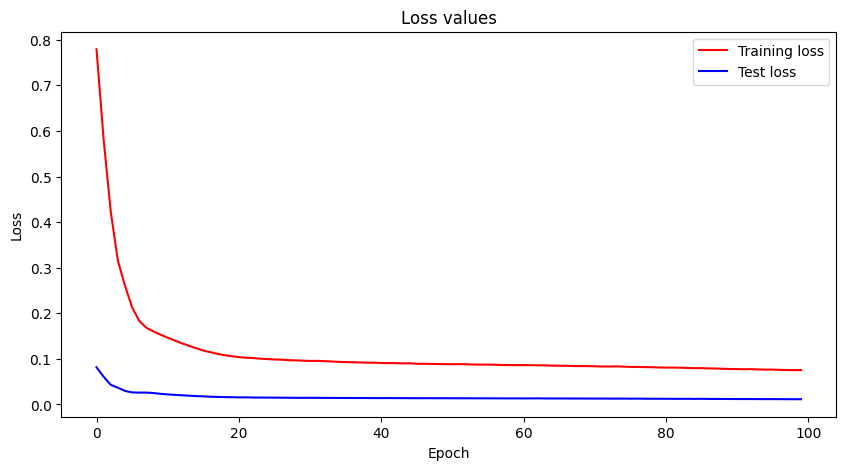

Test Predictions: tensor([[-7.2865e-03,  3.1692e+00,  1.5038e+00,  2.8484e+00, -3.5478e-02,
          9.3119e-01],
        [-1.7639e-02,  3.3357e+00,  1.5474e+00,  3.0991e+00, -4.0030e-02,
          1.0399e+00],
        [-1.5077e-02,  3.2275e+00,  1.5215e+00,  2.9925e+00, -3.5021e-02,
          9.4295e-01],
        ...,
        [-2.3083e-03,  2.6158e+00,  1.3009e+00,  1.5723e+00,  2.2844e-02,
         -4.6817e-03],
        [-2.3083e-03,  2.6158e+00,  1.3009e+00,  1.5723e+00,  2.2844e-02,
         -4.6817e-03],
        [-2.3083e-03,  2.6158e+00,  1.3009e+00,  1.5723e+00,  2.2844e-02,
         -4.6817e-03]], device='cuda:0')
Actual Values: tensor([[0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 1.],
        ...,
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.]], device='cuda:0')


In [27]:
# Hyperparameters
input_dim = 8
hidden_dim = 128
output_dim = 6
learning_rate = 0.001
num_epochs = 100
batch_size = 128

# Model and optimizer
model = GraphSequenceNN(input_dim, hidden_dim, output_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Initialize empty lists to store loss values
train_loss_values = []
test_loss_values = []

def evaluate_model(model, test_input_folder, batch_size, max_nodes, device):
    model.eval()
    total_loss = 0
    test_batch_generator, _ = load_sequence_data(test_input_folder, batch_size)
    with torch.no_grad():
        for test_batch in test_batch_generator:
            test_data = prepare_batch(test_batch, max_nodes)
            x_seq, edge_index_seq, x_last, edge_index_last, y, batch_last, seq_lengths = [t.to(device) for t in test_data]
            output = model((x_seq, edge_index_seq, x_last, edge_index_last, batch_last, seq_lengths))
            loss = masked_mse_loss(output, y)
            total_loss += loss.item()
    return total_loss

# Training and evaluation loop
for epoch in range(num_epochs):
    # Training
    model.train()
    total_train_loss = 0
    batch_generator, max_nodes = load_sequence_data(train_input_folder, batch_size)
    for batch in batch_generator:
        data = prepare_batch(batch, max_nodes)
        x_seq, edge_index_seq, x_last, edge_index_last, y, batch_last, seq_lengths = [t.to(device) for t in data]
        optimizer.zero_grad()
        output = model((x_seq, edge_index_seq, x_last, edge_index_last, batch_last, seq_lengths))
        loss = masked_mse_loss(output, y)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
    
    # Evaluation on test data
    total_test_loss = evaluate_model(model, test_input_folder, batch_size, max_nodes, device)
    
    # Append the losses of this epoch to the lists
    train_loss_values.append(total_train_loss)
    test_loss_values.append(total_test_loss)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {total_train_loss:.4f}, Test Loss: {total_test_loss:.4f}")

# Plot the loss values
plt.figure(figsize=(10,5))
plt.plot(train_loss_values, 'r', label='Training loss')
plt.plot(test_loss_values, 'b', label='Test loss')
plt.legend()
plt.title('Loss values')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Save the model
torch.save(model.state_dict(), 'model.pth')

# Final evaluation on test data
model.eval()
with torch.no_grad():
    test_batch_generator, _ = load_sequence_data(test_input_folder, batch_size)
    for test_batch in test_batch_generator:
        test_data = prepare_batch(test_batch, max_nodes)
        x_seq, edge_index_seq, x_last, edge_index_last, y, batch_last, seq_lengths = [t.to(device) for t in test_data]
        predictions = model((x_seq, edge_index_seq, x_last, edge_index_last, batch_last, seq_lengths))
        # Process predictions as needed
        print("Test Predictions:", predictions)
        print("Actual Values:", y)